In [43]:
# Import required libraries

import re
import string
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

# NLTK
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
stemmer= PorterStemmer()
lemmit=WordNetLemmatizer()

from sklearn.model_selection import train_test_split


# Visualization Libraries
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Import dataset

df=pd.read_csv('https://raw.githubusercontent.com/mohittomar2008/Rating-Prediction-over-reviews--NLP/main/review_comments_data.csv', index_col=0)
df.head(2)

,Title,Review,Rating
0,Terrible product,Its only 7 months I bought this product. It wa...,1
1,Absolute rubbish!,Automatically Disconnected so many times.,1


In [9]:
print("Dataset have ",df.shape[0] , 'rows and ', df.shape[1] ,'columns')

Dataset have  32431 rows and  3 columns


In [10]:
# We have 32,081 records and 3 features

In [11]:
df['Rating'].value_counts(normalize=True)

5    0.352348
1    0.253739
4    0.220561
3    0.104190
2    0.069162
Name: Rating, dtype: float64

In [12]:
df.duplicated().sum()

8164

In [14]:
# FIrst of all, we will remove duplicate entries which will not be usful for any prediction other than bias the model

df.drop_duplicates(inplace=True)

In [15]:
print("Dataset after removing duplicate entries is  ",df.shape[0] , 'rows and ', df.shape[1] ,'columns')

Dataset after removing duplicate entries is   24267 rows and  3 columns


In [16]:
df.sample(4)

,Title,Review,Rating
15268,Simply awesome,Best Price watch,5
21696,Absolute rubbish!,It did not print 20 pages even and Black Carti...,1
17630,Utterly Disappointed,Battery is very low,1
7419,Hated it!,third class head phone,1


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24267 entries, 0 to 32430
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Title   24266 non-null  string
 1   Review  24267 non-null  string
 2   Rating  24267 non-null  int64 
dtypes: int64(1), string(2)
memory usage: 758.3 KB


### Missing Values in Text data

In [35]:
df.isnull().sum()

Title     1
Review    0
Rating    0
dtype: int64

<AxesSubplot:>

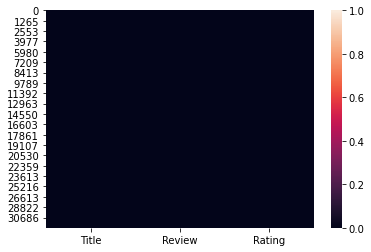

In [37]:
sns.heatmap(df.isnull())

We have only 1 null value in Title feature which is difficult to see in graph. As the missing value quantity is very less, we can drop this

In [38]:
df.dropna(inplace=True)

### Both Title and Review features are in Object datatype which should be in String datatype



In [ ]:
df['Title']=df['Title'].astype('string')
df['Review']=df['Review'].astype('string')

In [39]:
df['title_len']= df['Title'].apply(lambda x:len(x))
df['review_len']= df['Review'].apply(lambda x:len(x))

In [40]:
df.sample(3)

,Title,Review,Rating,title_len,review_len
13943,Great product,Its good,5,13,8
28120,Delightful,It's a good phone for the price,4,10,31
65,Utterly Disappointed,"Very Poor quality product, not charging proper...",1,20,214


In [21]:
X=df.iloc[:,0:2]
Y=df.iloc[:,2]

In [22]:
X.shape  , Y.shape

((24267, 2), (24267,))

,Title,Review,Rating
0,Terrible product,Its only 7 months I bought this product. It wa...,1
1,Absolute rubbish!,Automatically Disconnected so many times.,1


# Seprate Train and Test data

In [24]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=.3,random_state=42)

In [27]:
x_test.shape , y_test.shape

((7281, 2), (7281,))

In [48]:
x_train.shape , y_train.shape

((16986, 2), (16986,))

In [41]:
# Check any random input

df['Title'].loc[100]

'Worthless'

In [42]:
df['Review'].loc[100]

'Bluetooth connectivity is very poor..\nAfter on or off bluetooth not connect to mobile'

### Text Preprocessing

## Steps to Follow:
    Remove all email addresses
    Remove all website links if any
    Capture emojis
    Remove all special character
    
    Convert into lower case
    Stemmer/Lemmitizer to convert into base word

In [45]:
corpus=[]

for i in range(len(x_train)):
    p

SyntaxError: unexpected EOF while parsing (<ipython-input-45-7918b7ff1d8c>, line 4)

In [ ]:
corpus=[]

for i in range(len(train)):
    review=re.sub('([a-zA-Z0-9+._-]+@[a-zA-Z0-9._-]+\.[a-zA-Z0-9_-]+)','EMAIL',train['comment_text'][i])
    review=re.sub('[^a-zA-Z0-9]',' ',train['comment_text'][i])
    review=review.lower()
    review=review.split()
    
    review=[lemmit.lemmatize(word) for word in review if word not in set(stopwords.words('english'))]
    review=" ".join(review)
    corpus.append(review)
    